# Simple implementation of a CGAN using pytorch lightning

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
import pytorch_lightning as pl
from IPython import display

In [2]:
PATH_DATASETS = "/kaggle/working/"
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

In [3]:
class OneHotMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, num_classes=10):
        self.mnist = mnist_dataset
        self.num_classes = num_classes

    def __getitem__(self, index):
        image, label = self.mnist[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        return image, one_hot_label

    def __len__(self):
        return len(self.mnist)


class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = ToTensor()

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            mnist_full = OneHotMNIST(mnist_full, num_classes=self.num_classes)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
    
        if stage == "test" or stage is None:
            mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            self.mnist_test = OneHotMNIST(mnist_test, num_classes=self.num_classes)

    
    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.input_size = noise_dim + 10
        
        self.fc_net = nn.Sequential(
            nn.Linear(self.input_size, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (256, 7, 7))
        )

        self.conv_model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        noise, label = inputs
        x = torch.cat((noise, label), dim=1)
        y = self.fc_net(x)
        y = self.conv_model(y)
        return y

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_img = nn.Linear(10, 28*28)

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=5, stride=2, padding=2), # Input is 1 channel.
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Flatten(1),

            nn.Linear(4096, 1)
        )

    def forward(self, inputs):
        img, label = inputs
        label = self.label_img(label).view(-1, 1, 28, 28)
        x = torch.cat((img, label), dim=1)
        y = self.model(x)
        return y

In [7]:
class CGAN(pl.LightningModule):
    def __init__(self,
        noise_dim: int = 100,
        lr: float = 0.0002,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        # define the network structure
        self.generator = Generator(noise_dim)
        self.discriminator = Discriminator()

        # used to see intermediate ouputs after each epoch
        self.seed = torch.randn([10, noise_dim])
        self.seed_labels = torch.arange(10)
        self.seed_labels = F.one_hot(self.seed_labels, num_classes=10).float()

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, y_hat, y):
        loss_fn = nn.BCEWithLogitsLoss()
        return loss_fn(y_hat, y)

    def training_step(self, batch):
        imgs, labels = batch
 
        optimizer_g, optimizer_d = self.optimizers()
 
        # noise
        z = torch.randn(imgs.shape[0], self.hparams.noise_dim)
        z = z.type_as(imgs)
 
        # train generator
        # generate images
        self.toggle_optimizer(optimizer_g)
        inputs = z, labels
        self.generated_imgs = self(inputs)
 
        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
 
        # adversarial loss is binary cross-entropy
        inputs = self.generated_imgs, labels
        g_loss = self.adversarial_loss(self.discriminator(inputs), valid)
        optimizer_g.zero_grad()
        self.manual_backward(g_loss)
        optimizer_g.step()
        self.untoggle_optimizer(optimizer_g)

        self.log("g_loss", g_loss, on_step=False, on_epoch=True, prog_bar=True)
 
        # train discriminator
        # Measure discriminator's ability to classify real from generated samples
        self.toggle_optimizer(optimizer_d)
        
        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        inputs = imgs, labels
        real_loss = self.adversarial_loss(self.discriminator(inputs), valid)
 
        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        inputs = self.generated_imgs.detach(), labels
        fake_loss = self.adversarial_loss(self.discriminator(inputs), fake)
 
        d_loss = real_loss + fake_loss
        optimizer_d.zero_grad()
        self.manual_backward(d_loss)
        optimizer_d.step()
        self.untoggle_optimizer(optimizer_d)
        
        self.log("d_loss", d_loss, on_step=False, on_epoch=True, prog_bar=True)
        
        display.clear_output(wait=True)

    def validation_step(self, batch, batch_idx):
        pass
 
    def configure_optimizers(self):
        lr = self.hparams.lr
 
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def on_validation_epoch_end(self):
        seed = self.seed.type_as(self.generator.fc_net[0].weight)
        seed_labels = self.seed_labels.type_as(self.generator.fc_net[0].weight)

        # log sampled images
        predictions = self((seed, seed_labels)).detach().cpu()* 250
        grid = make_grid(predictions, 5).numpy().squeeze().transpose(1, 2, 0)
        plt.imshow(grid.astype(np.uint8) , cmap='binary')
        plt.show()

In [8]:
class LossTracker(pl.Callback):
    def __init__(self):
        self.g_losses = []
        self.d_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        g_loss = trainer.callback_metrics.get("g_loss")
        d_loss = trainer.callback_metrics.get("d_loss")

        if g_loss is not None:
            self.g_losses.append(g_loss.item())
        if d_loss is not None:
            self.d_losses.append(d_loss.item())


Validation: |          | 0/? [00:00<?, ?it/s]

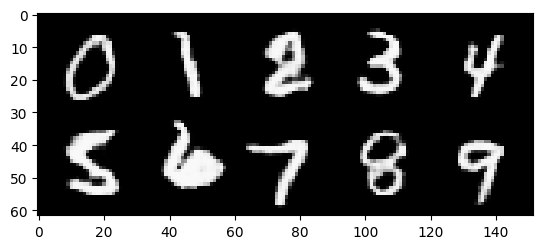

In [9]:
dm = MNISTDataModule()
model = CGAN()
loss_tracker = LossTracker()
trainer = pl.Trainer(
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=30,
    callbacks=[loss_tracker]
)
trainer.fit(model, dm)

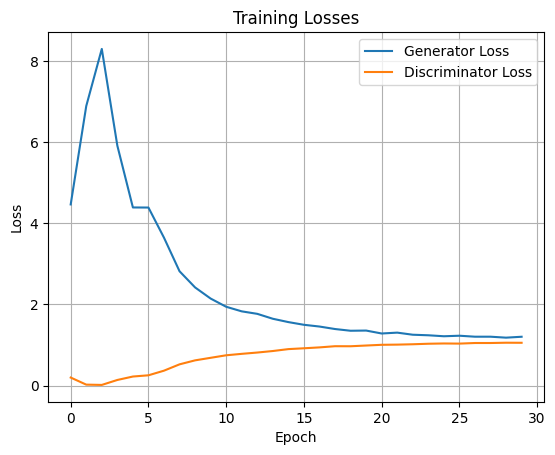

In [10]:
plt.plot(loss_tracker.g_losses, label="Generator Loss")
plt.plot(loss_tracker.d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()